In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170508288/170498071 [==============================] - 3s 0us/step


(50000, 32, 32, 3)

In [3]:
train_x = train_x.astype('float32')
train_x = (train_x - 127.5) / 127.5 

print("max pixel:", np.amax(train_x))
print("min pixel:", np.amin(train_x))

max pixel: 1.0
min pixel: -1.0


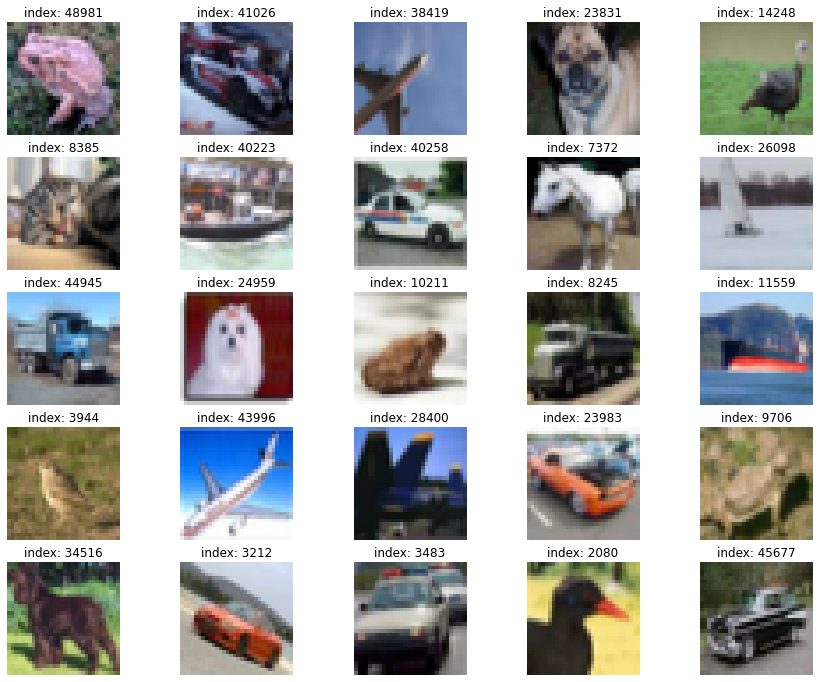

In [4]:
plt.figure(figsize=(15, 12))

for i in range(25):
    rn = np.random.randint(train_x.shape[0])
    plt.subplot(5, 5, i+1)
    Image = np.clip(train_x[rn], 0, 1)
#     plt.imshow(Image.reshape(32, 32, 3))
    plt.imshow((train_x[rn] + 1)/2.0)
    plt.title(f'index: {rn}')
    plt.axis('off')
    
plt.show()

In [5]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [6]:
def make_generator_model(momentum=0.9, alpha=0.2):
    dropout = 0.4
    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(4*4*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization(momentum=momentum))
    model.add(layers.LeakyReLU(alpha=alpha))
    
    model.add(layers.Reshape(( 4, 4, 512)))
    model.add(layers.Dropout(dropout))
    # First Layer
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 256)
    model.add(layers.BatchNormalization(momentum=momentum))
    model.add(layers.LeakyReLU(alpha=alpha))
    
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization(momentum=momentum))
    model.add(layers.LeakyReLU(alpha=alpha))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)
    return model

In [7]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8192)              819200    
_________________________________________________________________
batch_normalization (BatchNo (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         3276800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1

In [8]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

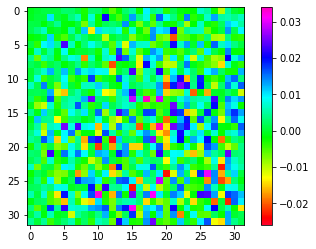

In [9]:
plt.imshow(generated_image[0, :, :, 0], cmap ='gist_rainbow')
plt.colorbar()
plt.show()

In [10]:
def make_discriminator_model(alpha=0.2):
    dropout = 0.4
    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Dropout(dropout))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Dropout(dropout))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))
    

    return model


In [11]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 128)       9728      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 256)         819456    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 256)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)            

In [12]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00086818]], dtype=float32)>

In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# 손실 함수

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [14]:
# 최적화 함수

generator_optimizer = tf.keras.optimizers.Adam(4e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(8e-4, beta_1=0.5)

noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [15]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [16]:
# 예측 이미지를 파일에 저장
# gif 파일 생성을 위함
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i] + 1)/2.0)
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [17]:
# training_history 생성
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [18]:
# 체크 포인트 만들기
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [19]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [20]:
save_every = 5
EPOCHS = 50

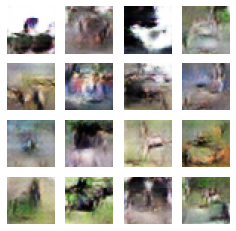

Time for training : 2131 sec


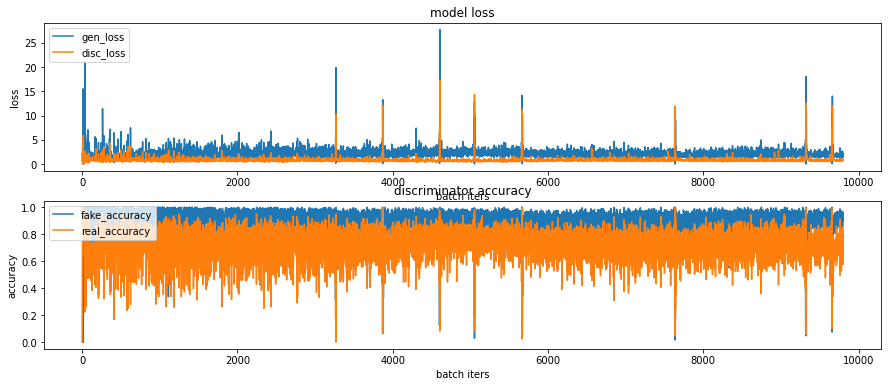

CPU times: user 38min 16s, sys: 2min 8s, total: 40min 25s
Wall time: 35min 32s


In [21]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

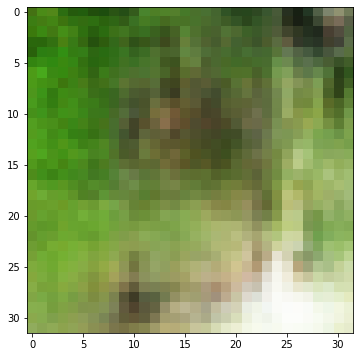

In [22]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [23]:
save_every = 5
EPOCHS = 50

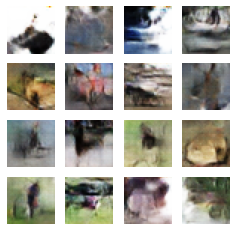

Time for training : 2128 sec


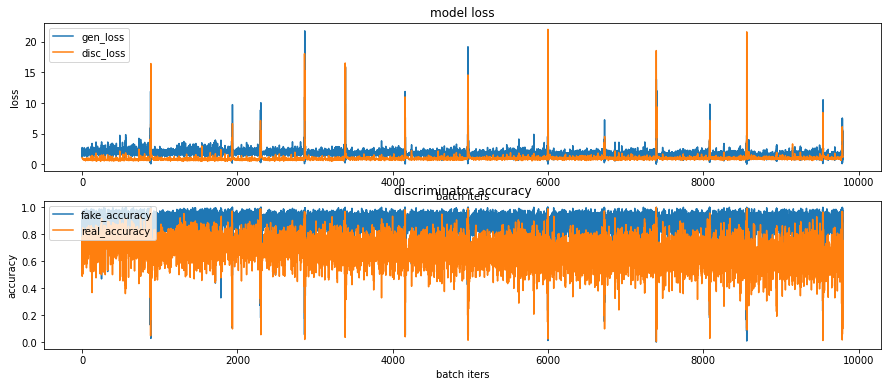

CPU times: user 38min 14s, sys: 2min 6s, total: 40min 20s
Wall time: 35min 29s


In [24]:
%%time
train(train_dataset, EPOCHS, save_every)

In [25]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/second.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1036586 Feb 14 03:39 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


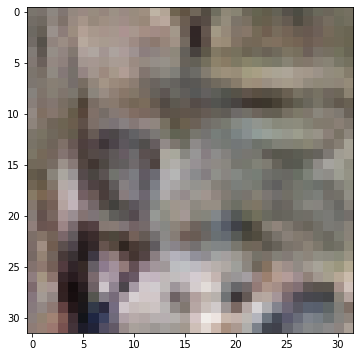

In [26]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

# GAN 훈련 과정 개선하기

# Epoch 늘리기

In [27]:
EPOCHS = 100

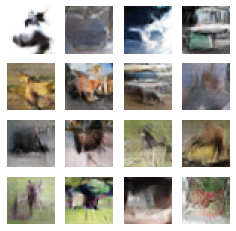

Time for training : 4295 sec


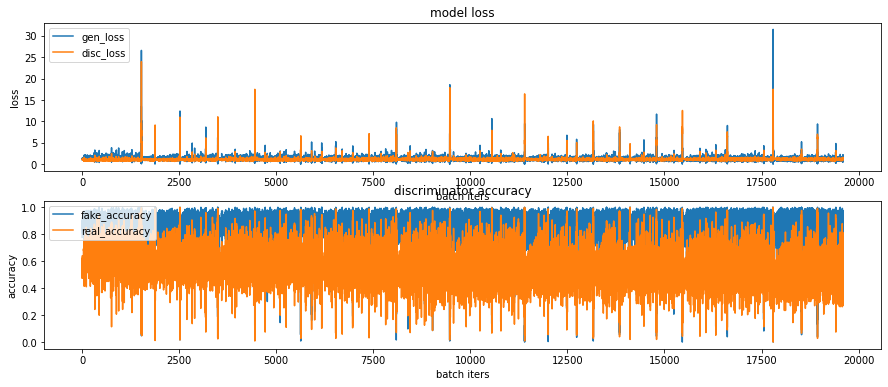

CPU times: user 1h 17min 10s, sys: 4min 12s, total: 1h 21min 23s
Wall time: 1h 11min 36s


In [28]:
%%time
train(train_dataset, EPOCHS, save_every)

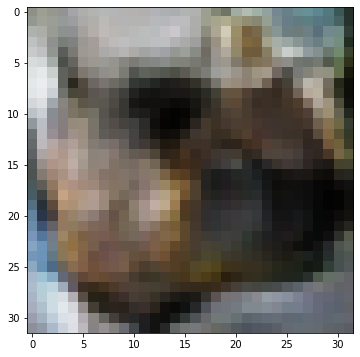

In [29]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

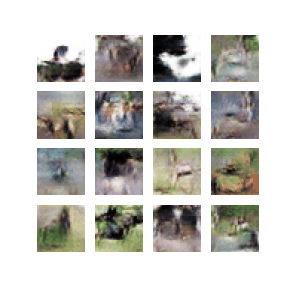

# 회고 

### GAN의 단점 
: 이미지를 생성해서 이미지를 확인하는 것이 목적인데, 그래프의 수치가 그림의 정확도와 비례하지 않다. 
교육시간이 너무 오래 걸린다. 
Epoch를 많이 늘리면 교육이 잘되긴 하지만, 무한정 늘린다고 해서 결과가 항상 개선된다는 것도 확실하지 않다. 


### Check point module
모델 재학습을 할 필요 없이 모델을 로드할 수 있어 시간을 단축할 수 있다. 

### gif 

초반에 학습이 부족했을 때는 형체가 제대로 구별되지 않았다. 
또한, 채색도 탁한 느낌이 들어 유화로 그린 추상화를 보는 듯 했다. 
세 번의 학습 과정이 지났고, 마지막 학습 과정에서는 100 epochs로 진행했다. 
그 결과, 서 있는 말의 이미지, 몸을 웅크리고 앉아 있는 노루의 이미지 등을 확인할 수 있었다. 생성된 이미지 중에서 유독 서 있는 말의 이미지가 많아 보이는 것은 기분 탓일까? 말의 이미지가 학습이 많이 된 것일까?


###  Neural Style Transfer 와의 접목

같은 Computer Vision 분야에서 사용되는 Neural Style Transfer와의 접목을 생각하게 되었다. 

---

* Neural Style Transfer의 원리는 2가지의 다른 함수를 정의하는 것이다. 
1. Lcontent : 두 이미지의 내용이 어떻게 차이가 나는 지를 설명한다. 
2. Lstyle : 두 이미지의 스타일 차이를 설명한다. 

이후, 아래의 3가지 이미지를 제공함으로써 입력 이미지를 변환해서 콘텐츠 이미지와 스타일의 차이를 최소화한다. 

(1)원하는 스타일 이미지
(2)원하는 콘텐츠의 이미지
(3)(콘텐츠 이미지로 초기화된) 입력 이미지

---

CIFAR-10과 Neural Style Transfer와 접목하게 될 경우,
새로운 이미지를 만들고 그 위에 기존에 존재하는 스타일을 입힐 수 있다는 생각이 들었다.

하지만, 그럴 바에 차라리 처음부터 원하는 스타일의 이미지로 학습 시키는 게 낫지 않을까? 

(1) 원하는 스타일의 이미지를 모으고, CIFAR-10을 이용해 새로운 이미지를 생성하는 것
(2) CIFAR-10을 이용해 새로운 이미지를 생성한 후, Neural Style Transfer를 이용해 스타일을 변환시키는 것

위 두 가지 방법을 진행시킨 경우 결과물의 차이가 궁금하다. 

- 사용자가 하나의 스타일만을 추구한다면 (1)번 방법이 좋을 것 같다. 
- 하지만, 다양한 스타일의 이미지를 추구한다면 (2)번 방법이 더 나은 방법이다. 이미지를 학습시키고 생성하는 시간이 오래 걸리기 때문에, 이미지를 생성한 후에 Neural Style Transfer에 변주하는 것이 사용자의 목적에 맞게 효율적으로 프로그램을 만들 수 있는 방법이라 생각한다.  


(출처 : https://github.com/KerasKorea/KEKOxTutorial/blob/master/15_Neural_Style_Transfer_Creating_Art_with_Deep_Learning_using_tf.keras_and_eager_execution.md)

---

# 응용 : 역사 사료의 복원

회고를 적고 나니, 회고를 쓰기 이전보다 더욱 많은 생각이 듭니다. 
회고는 시작하기 전에는 막막하지만 적기 시작하면 멈출 수 없이 생각이 밀려듭니다. 

이번 "Exploration 10 : CIFAR-10 이미지 생성하기"에서는 기존의 이미지를 학습하고 새로운 이미지를 생성하는 것을 목표로 하고 있습니다. 바로 위에서 (1) Only CIFAR-10 (2) CIFAR-10 with Neural Style Transfer 에 대해서 이야기했습니다. 

CIFAR-10만을 사용하는 예시를 적던 중 역사 사료를 복원하는데 사용할 수 있겠다는 확신이 들었습니다. (물론, CIFAR-10보다 CIFAR-100이나 학습을 더욱 디테일하게 할 수 있으면 더 좋겠습니다.)

##### "한국 전통 미술 작품을 학습시키면 한국 전통 미술의 화풍을 익힐 수도 있겠다. 그렇다면, 당연히 그 이미지 속에 있는 대상도 학습하는게 당연하네!"

(생각의 흐름) 로코코 화풍의 그림만 모은다. -> 한국 전통미술작품만 모은다. -> 한국 역사의 시대별 의상만을 모아서 그 시대의 의복을 재구현한다. -> 의복은 큰 변화보다는 약간의 변형이 있을 것이다. 그렇다면 발견하지 못한 옛날의 의복을 구현할 수도 있겠다.

- 우리가 알고 있는 한복의 형태는 조선 후기의 한복 형태 중 하나라고 생각합니다. 아주 오래 전으로 거슬러 올라가서 고조선, 삼국시대, 남북국시대, 고려, 조선을 거치면서 오랜 시간동안 다양한 의복의 형태가 존재한 것은 당연한 일입니다. 
- 실제로 조선시대에도 한복의 형태는 다양했다고 합니다. 저고리의 길이나 소매, 옷깃이나 옷고름의 디테일, 치마의 폭이나 형태도 다양했습니다. 


###### 예시

1. 전쟁이나 보관 실수로 일부 손실된 그림을 복구하는데 사용할 수 있습니다.
2. 아직 발견되지 않은 사료를 찾아 내는데 사용할 수 있습니다. 


아마 이 회고를 보면서, 과거에 존재했지만 발견하지 못한 사료를 복원하기 위해, '이미지 생성'을 이용하는 것이 말이 안된다고 생각하시는 분들도 있을 것 같습니다. 사료는 실존했던 것이지만, 새로운 이미지는 허구이기 때문이겠죠?

당연히 지나가버린 과거는 되돌릴 수 없습니다. 그렇게 때문에 역사가가 과거의 '사실'을 직접 만나는 것은 불가능합니다. 그래서 남겨진 사료를 매개로 해서 과거와 만납니다. 기록된 사료도 허구일 지 모른다는 의심을 버리지 않고 확인해야 하지만, 그 '허구'의 사료 속에도 그 당시의 시대적 상황과 풍속을 발견할 수 있습니다. 

- 사료의 불완전성은 연구의 범위를 제한하지만, 그 불완전성 때문에 역사학이 학문이 될 수 있으며, 역사는 끝없이 다시 서술된다. 
(인용 : 참고자료1)

역사는 기록한 사람들의 주관이 담긴 기술입니다. 우리가 알고 있는 '공식 역사'도 역사학자들 사이에서 토론과 논쟁을 거친 후에 '인정'된 내용이 많습니다. 그래서 역사에 대한 해석도 변할 수 있습니다. 해석하는 사람과 해석하는 시대에 따라 계속 변화합니다. 

새로운 사료를 발굴하는 것만큼 중요한 것이 역사학적 사고력을 토대로 기존에 있는 사료에서 새로운 사실을 밝혀내는 것이라고 생각합니다. 


# 응용+ : CV와 NLP의 접목
(1) [NLP] Lyricist만들기에 사용된 NLP를 이용한다면 과거 문학 자료를 통해서 당시 시대상, 특히 당시에는 특별하지 않아 소외된 평범한 사람들의 생활상, 풍속, 언어습관 등을 재발견할 수 있겠네요! 

(2) [CV] 그렇다면 전통 미술을 학습시켜 CIFAR으로 생성한 이미지와 함께 이용한다면 어떨까요? 역사를 재현하고 역사를 재생산하는데 큰 도움이 되겠네요!


혹시나 여기까지 읽으셨다면...?! 출처의 자료도 읽어보세요! 재밌는 자료들입니다.





(출처)

1. https://m.blog.naver.com/ggumtl_edu/221731842885
2. https://www.naeiledu.co.kr/29819
3. http://m.naeil.com/m_news_view.php?id_art=400711
4. https://www.koreascience.or.kr/article/JAKO200514860966455.pdf
